In [2]:
! pip install -U pandas

    100% |################################| 10.1MB 98kB/s  eta 0:00:01
    100% |################################| 512kB 2.2MB/s eta 0:00:01
    100% |################################| 17.0MB 77kB/s  eta 0:00:01
    100% |################################| 235kB 5.3MB/s eta 0:00:01
  Found existing installation: pytz 2017.2
    Uninstalling pytz-2017.2:
      Successfully uninstalled pytz-2017.2
  Found existing installation: numpy 1.13.1
    Uninstalling numpy-1.13.1:
      Successfully uninstalled numpy-1.13.1
  Found existing installation: six 1.10.0
    Uninstalling six-1.10.0:
      Successfully uninstalled six-1.10.0
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
  Found existing installation: pandas 0.20.3
    Uninstalling pandas-0.20.3:
      Successfully uninstalled pandas-0.20.3
You are using pip version 9.0.1, however version 21.1 is available.
You should consider upgrading via 

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from ripser import Rips
import seaborn as sns
import numpy as np

In [5]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load Data

In [9]:
embeds = np.load('/notebooks/subgraphs/graph_embeds.npy')
embeds_tda = np.load('/notebooks/subgraphs/graph_embeds_tda.npy')
labels = np.load('/notebooks/subgraphs/graph_labels.npy')

In [12]:
feat_cols = ['feat-{}'.format(i) for i in range(embeds.shape[1])]
feat_tda_cols = ['feat-{}'.format(i) for i in range(embeds_tda.shape[1])]
class_cols = ['class-{}'.format(i) for i in range(labels.shape[1])]

In [13]:
train_embed = pd.DataFrame(embeds, columns=feat_cols)
train_embed_tda = pd.DataFrame(embeds_tda, columns=feat_tda_cols)
train_label = pd.DataFrame(labels, columns=class_cols)

# PCA

In [14]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_embed[feat_cols].values)

In [15]:
train_embed['pca-one'] = pca_result[:,0]
train_embed['pca-two'] = pca_result[:,1] 
train_embed['pca-three'] = pca_result[:,2]

In [16]:
print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)

Explained variation per principal component: [0.53465706 0.25287223 0.21247064]


In [17]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(train_embed.shape[0])

### Get Integer Labels

In [18]:
labels = [train_label.iloc[i,:].to_string(header=False, index=False) for i in range(len(train_label))]

In [19]:
labels_set = set(labels)
print 'Number of Unique Labels: {}'.format(len(labels_set))

Number of Unique Labels: 4


In [20]:
label2int = dict([(y,x+1) for x,y in enumerate(labels_set)])

In [21]:
train_embed['y'] = pd.Series([label2int[x] for x in labels])

## 2D Projection

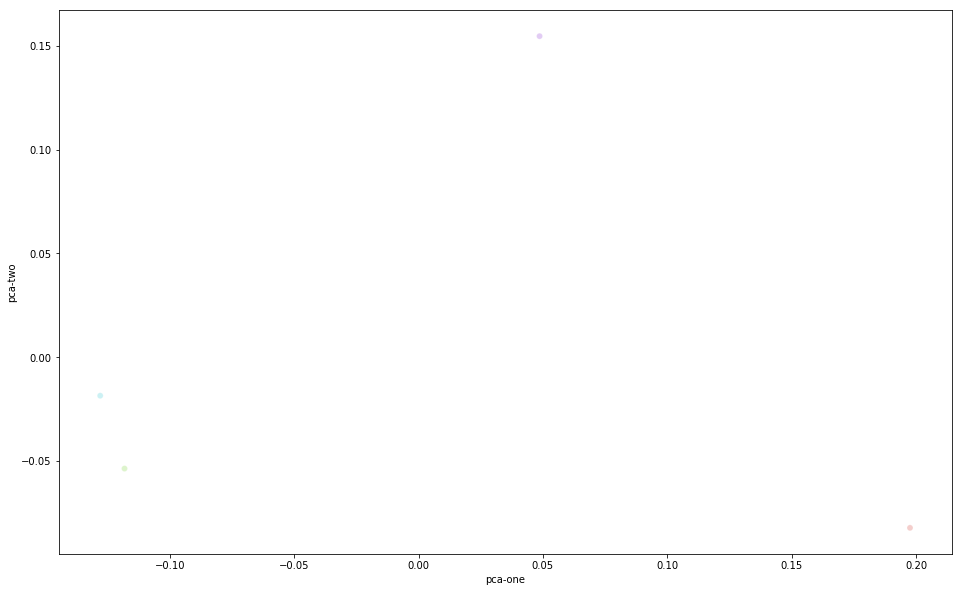

In [22]:
n_color = len(train_embed.loc[rndperm]['y'].unique())
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", n_color),
    data=train_embed.loc[rndperm,:],
    legend=False,
    alpha=0.3
)

## 3D Projection

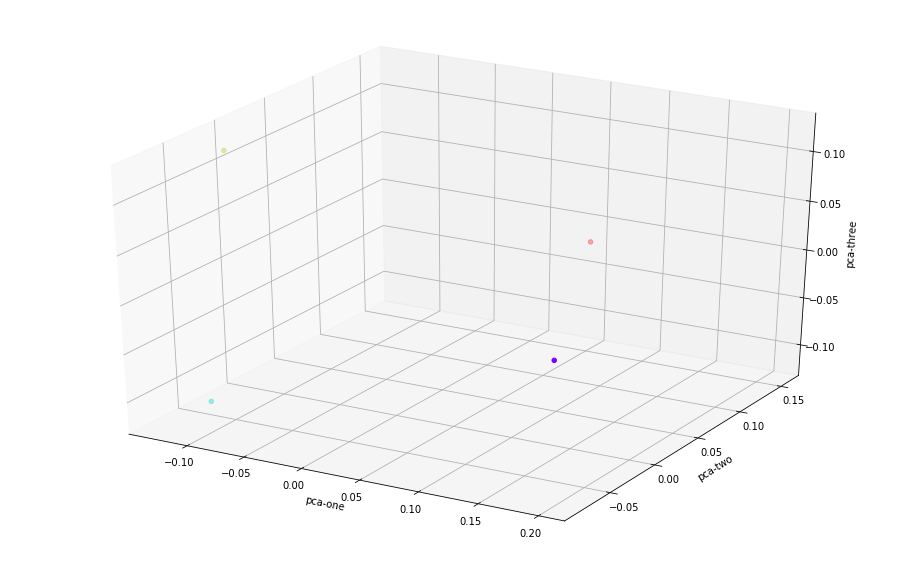

In [23]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=train_embed.loc[rndperm,:]["pca-one"], 
    ys=train_embed.loc[rndperm,:]["pca-two"], 
    zs=train_embed.loc[rndperm,:]["pca-three"], 
    c=train_embed.loc[rndperm,:]["y"],
    cmap='rainbow'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Ripser

## Persistence Diagram

In [24]:
train_embed.shape

(4, 260)

In [25]:
# rips = Rips(maxdim=2)
rips = Rips()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [26]:
diagrams = rips.fit_transform(train_embed.drop(columns=['pca-one', 'pca-two', 'pca-three', 'y']))

/usr/local/lib/python2.7/dist-packages/ripser/ripser.py:221: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  + "did you mean to transpose?"


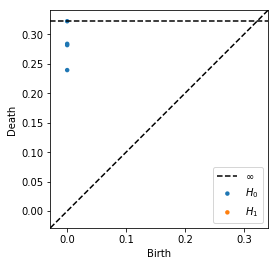

In [27]:
rips.plot(diagrams)

## Persistence Transform

In [28]:
lifetime_dim0_pts = diagrams[0][:, 1] - diagrams[0][:, 0] 
lifetime_dim1_pts = diagrams[1][:, 1] - diagrams[1][:, 0] 
# lifetime_dim2_pts = diagrams[2][:, 1] - diagrams[2][:, 0]

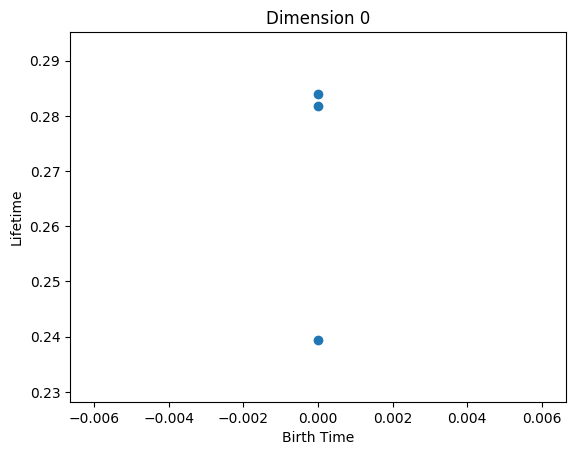

In [29]:
plt.scatter(diagrams[0][:, 0], lifetime_dim0_pts)
plt.title('Dimension 0')
plt.xlabel('Birth Time')
plt.ylabel('Lifetime')
plt.show()

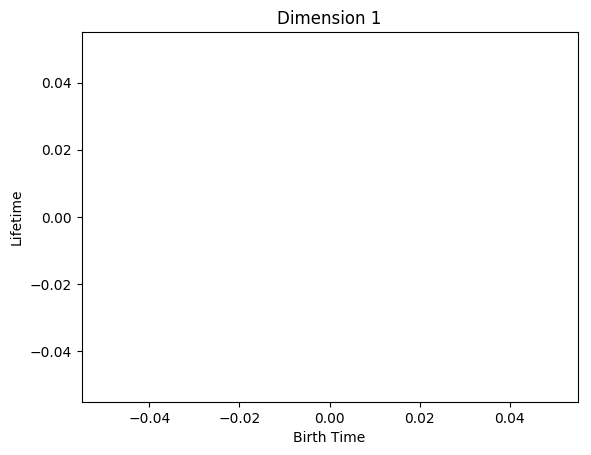

In [30]:
plt.scatter(diagrams[1][:, 0], lifetime_dim1_pts)
plt.title('Dimension 1')
plt.xlabel('Birth Time')
plt.ylabel('Lifetime')
plt.show()

In [31]:
# plt.scatter(diagrams[2][:, 0], lifetime_dim2_pts)
# plt.title('Dimension 2')
# plt.xlabel('Birth Time')
# plt.ylabel('Lifetime')
# plt.show()

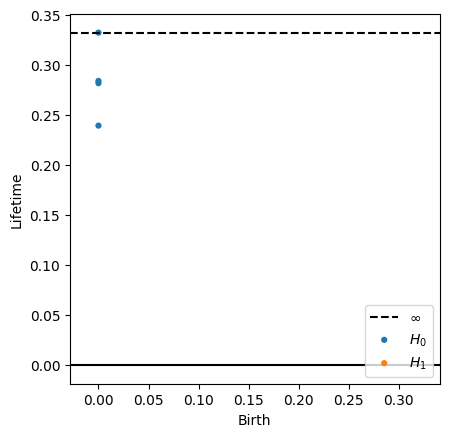

In [32]:
rips.plot(diagrams, lifetime=True)

In [33]:
train_embed['birth_dim0'] = pd.Series(data=diagrams[0][:, 0])
train_embed['lifetime_dim0'] = pd.Series(data=lifetime_dim0_pts)

In [34]:
train_embed['birth_dim1'] = pd.Series(data=diagrams[1][:, 0])
train_embed['lifetime_dim1'] = pd.Series(data=lifetime_dim1_pts)

In [35]:
# train_embed['birth_dim2'] = pd.Series(data=diagrams[2][:, 0])
# train_embed['lifetime_dim2'] = pd.Series(data=lifetime_dim2_pts)

In [36]:
train_embed.columns

Index([u'feat-0', u'feat-1', u'feat-2', u'feat-3', u'feat-4', u'feat-5',
       u'feat-6', u'feat-7', u'feat-8', u'feat-9',
       ...
       u'feat-254', u'feat-255', u'pca-one', u'pca-two', u'pca-three', u'y',
       u'birth_dim0', u'lifetime_dim0', u'birth_dim1', u'lifetime_dim1'],
      dtype='object', length=264)

In [50]:
# Is concatenating like this okay?
# print(train_embed['lifetime_dim1'].shape)
# print(train_embed['lifetime_dim0'].shape)